In [42]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import time
import matplotlib.pyplot as plt

In [43]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0


## Load GeneMANIA Raw Data
**Source: http://genemania.org/data/archive/2021-04-19/Homo_sapiens.COMBINED/COMBINED.DEFAULT_NETWORKS.BP_COMBINING.txt**   
Downloaded: November, 2021  
Last Updated: April 19, 2021

In [44]:
input_raw_v2 = pd.read_csv(wd+'/Network_Data_Raw/GeneMania_2021_COMBINED.DEFAULT_NETWORKS.BP_COMBINING.txt',sep='\t')

In [45]:
genes_v2 = list(set(input_raw_v2['Gene_A']).union(set(input_raw_v2['Gene_B'])))

In [46]:
# Get Edgelist of network
edgelist_v2 = input_raw_v2[['Gene_A','Gene_B', 'Weight']].values.tolist()
print(len(edgelist_v2), "Total GeneMANIA Edges")

11749785 Total GeneMANIA Edges


## Convert Genes (from uniprot to gene symbol)

In [47]:
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(genes_v2)

19680 Valid Query Genes
0 Invalid Query Genes


In [48]:
ensembl_genes = [gene for gene in valid_genes_v2 if "ENSG" in gene]

In [49]:
# Set scopes (gene naming systems to search)
scopes = "uniprot,ensemblgene"

# Set fields (systems from which to return gene names from)
fields = "symbol,entrezgene"

In [50]:
# Query MyGene.Info
match_list_v2 = gct.query_batch(query_string_v2, scopes=scopes, fields=fields)

100%|██████████| 20/20 [00:15<00:00,  1.28it/s]

19859 Matched query results
Batch query complete: 15.58 seconds


In [52]:
match_list_v2 = pd.DataFrame.from_dict(match_list_v2)

In [99]:
# Get unmapped values, query against uniprot
missing = match_list_v2[match_list_v2.notfound==True]["query"].tolist()
missing_ensg = [gene for gene in missing if "ENSG" in gene]
missing_uni = [gene for gene in missing if "ENSG" not in gene]

In [102]:
uniprot_ids, _ = gct.query_uniprot(missing_uni, return_as_dict=False, source_fmt="ACC+ID", target_fmt="ACC")
ensg_ids, _ = gct.query_uniprot(missing_ensg, return_as_dict=False, source_fmt="ENSEMBL_ID", target_fmt="ACC")

In [103]:
missing_ACC = pd.concat([uniprot_ids, ensg_ids])

In [118]:
missing_names, _ = gct.query_uniprot(missing_ACC.ACC.tolist(), return_as_dict=False, source_fmt="ACC+ID", target_fmt=["GENENAME", "P_ENTREZGENEID"])

In [120]:
missing_names = missing_names.merge(missing_ACC, left_on=["query", "_score"], right_on=["ACC", "_score"], how="outer")

In [123]:
missing_names = missing_names.loc[:, ("query_y", "entrezgene", "symbol", "_score")].drop_duplicates()
missing_names.columns = ["query", "entrezgene", "symbol", "_score"]

In [124]:
final_mapping = pd.concat([match_list_v2.loc[~match_list_v2["query"].isin(missing_names["query"]), 
                                             ("query", "entrezgene", "symbol", "_score")], 
                           missing_names])

,query,entrezgene,symbol,_score
0,Q6ZUT3,90167,FRMD7,19.670908
1,P58511,54065,SMIM11,18.816320
2,P58511,102723553,LOC102723553,18.816320
3,Q9BY66,8284,KDM5D,18.814915
4,Q8NH56,390075,OR52N5,19.657969


In [127]:
check_names_v2 = final_mapping.symbol.values
mapped_v2, unmapped_v2 = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              check_names_v2, return_as_dict=False)

In [129]:
# Get final gene mapping
final_symbols = final_mapping.merge(mapped_v2,left_on=["symbol"], right_on=["Query"], how='outer', 
                                    suffixes=["", "-y"]).loc[:, ("query", "Approved symbol", "NCBI Gene ID", "_score")]
final_symbols.columns = ["query", "symbol", "entrezgene", "_score"]

In [135]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(final_symbols, valid_genes_v2,
                                                                                display_unmatched_queries=False)

Number of genes with multiple matches: 192
Number of unmatched genes: 375
Number of fully matched genes: 19201
Number of partially matched genes: 479


## Construct Converted Network

In [136]:
edgelist_updated_v2 = gct.convert_edgelist(edgelist_v2, query_to_symbol_v2, weighted=True)

In [138]:
# Filter converted edge list
edgelist_filt_v2 = gct.filter_converted_edgelist(edgelist_updated_v2, weighted=True)

11749785 input edges
406 self-edges removed
38012 edges with un-mapped genes removed
11839 duplicate edges removed
Edge list filtered: 53.23 seconds
11699528 Edges remaining


In [139]:
# Write network to file
gct.write_edgelist(edgelist_filt_v2, wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA_Symbol_2021.sif', binary=False)

Edge list saved: 20.89 seconds


In [140]:
# Create filtered network
edgelist_90_v2 = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA_Symbol_2021.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                       q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA90_Symbol_2021.sif')

90.0% score: 9.5e-05
1164500 / 11699528 edges retained


# Version 1.0 (original)

## Load GeneMANIA Raw Data
**Source: http://genemania.org/data/current/Homo_sapiens.COMBINED/COMBINED.DEFAULT_NETWORKS.BP_COMBINING.txt**  
Downloaded: July 28, 2016  
Last Updated: October 15, 2014	

2021 Note: There are minor differences in processing when re-running on the original dataset due to changes in ensembl database

In [5]:
input_raw = pd.read_csv(wd+'/Network_Data_Raw/GeneMANIA_2014_10_15.txt',sep='\t')

In [6]:
genes = list(set(input_raw['Gene_A']).union(set(input_raw['Gene_B'])))

In [7]:
# Get Edgelist of network
edgelist = input_raw[['Gene_A','Gene_B', 'Weight']].values.tolist()
print(len(edgelist), "Total GeneMANIA Edges")

7290094 Total GeneMANIA Edges


## Convert Genes (from ensembl gene to gene symbol)

In [9]:
query_string, valid_genes, invalid_genes = gct.query_constructor(genes)


19264 Valid Query Genes
0 Invalid Query Genes


In [10]:
# Set scopes (gene naming systems to search)
scopes = "ensemblgene"

# Set fields (systems from which to return gene names from)
fields = "symbol,entrezgene"

In [11]:
# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 20/20 [00:17<00:00,  1.14it/s]

19264 Matched query results
Batch query complete: 17.57 seconds
19264 Matched query results


In [13]:
match_list = pd.DataFrame.from_dict(match_list)

In [14]:
check_names = match_list["symbol"].values

In [15]:
mapped, unmapped = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              check_names, return_as_dict=False)

In [22]:
final_mapping = match_list.merge(mapped, left_on=["symbol"], right_on=["Query"], 
                                 how="outer").loc[:, ("query", "entrezgene", "_score", "Approved symbol")]
final_mapping.columns = ["query", "entrezgene", "_score", "symbol"]

In [23]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(final_mapping, valid_genes)

Number of genes with multiple matches: 3
Number of unmatched genes: 1405
Number of fully matched genes: 17739
Number of partially matched genes: 1525


## Construct Converted Network

In [24]:
edgelist_updated = gct.convert_edgelist(edgelist, query_to_symbol, weighted=True)

In [25]:
# Filter converted edge list
edgelist_filt = gct.filter_converted_edgelist(edgelist_updated, weighted=True)

7290094 input edges
9 self-edges removed
753748 edges with un-mapped genes removed
423 duplicate edges removed
Edge list filtered: 48.98 seconds
6535914 Edges remaining


In [26]:
# Write network to file
gct.write_edgelist(edgelist_filt, wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA_Symbol_2014.sif', binary=False)

Edge list saved: 15.83 seconds


In [27]:
# Create filtered network
edgelist_90 = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA_Symbol_2014.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                       q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA90_Symbol_2014.sif')

90.0% score: 0.00023
613344 / 6535914 edges retained


# Changes

**Gene Identifiers** : Now given as UniProt IDs rather than ensembl gene ids

No human filtering done


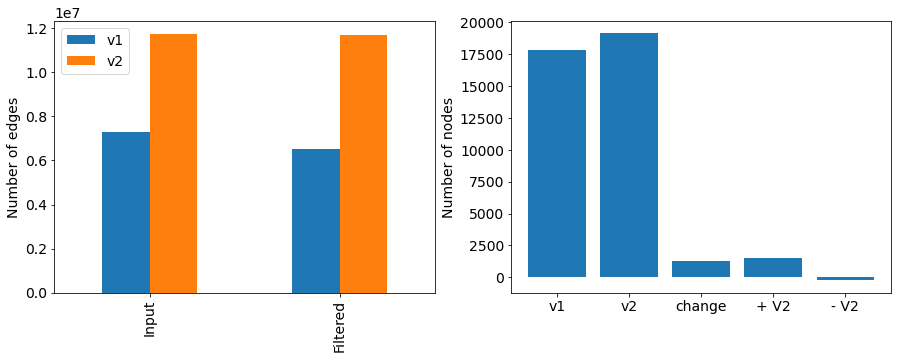

In [141]:
dit.plot_changes_to_dataset(input_raw, input_raw_v2, edgelist_filt, edgelist_filt_v2)